<a href="https://colab.research.google.com/github/icfire21/Trading_Challenge/blob/main/Optiver_Trading_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Optiver Competition**



Aim is to build a model to predict the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock.

# **1. Building a Baseline Model**

Building a baseline model, by feeding the training data into LightBGM model

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# import optuna

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgbm

# optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
warnings.filterwarnings('ignore')

from lightgbm import *
pd.set_option("display.max_columns", None)

In [ ]:
# pip install optuna

In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
sample_sub = pd.read_csv('/content/sample_submission.csv')
rev_target = pd.read_csv('/content/revealed_targets.csv')

In [ ]:
df_train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.000000,0.000000,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0.0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.000000,0.000000,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0.0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.000000,0.000000,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0.0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.000000,0.000000,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0.0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.000000,0.000000,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0.0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861552,152,80,530,303836.89,-1,1.000410,13733706.47,0.999722,1.000324,1.000324,45712.45,1.000697,5236.20,1.000659,-0.020266,4453.0,80_530_152
861553,153,80,530,27050.30,1,1.004068,269056.21,1.004068,1.004068,1.001787,12407.40,1.004068,15407.00,1.002806,-2.290011,4453.0,80_530_153
861554,154,80,530,0.00,0,0.999615,9426415.84,0.999615,0.999615,0.999615,274648.52,1.000023,52003.60,0.999958,-6.240010,4453.0,80_530_154
861555,155,80,530,0.00,0,1.006306,4844892.35,1.006306,1.006306,1.005836,2568.00,1.006306,242596.71,1.005841,-32.079815,4453.0,80_530_155


In [ ]:
df_test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0,False
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.000000,26290,478_0_1,False
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.000000,26290,478_0_2,False
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.000000,26290,478_0_3,False
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.000000,26290,478_0_4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195,False
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196,False
32997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,26454,480_540_197,False
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198,False


In [ ]:
rev_target_modified = rev_target.dropna()
rev_target_modified

,stock_id,date_id,seconds_in_bucket,time_id,revealed_target,revealed_date_id,revealed_time_id
0,0.0,478,0,26290,-2.310276,477.0,26235.0
1,1.0,478,0,26290,-12.850165,477.0,26235.0
2,2.0,478,0,26290,-0.439882,477.0,26235.0
3,3.0,478,0,26290,7.259846,477.0,26235.0
4,4.0,478,0,26290,4.780292,477.0,26235.0
...,...,...,...,...,...,...,...
33103,195.0,480,540,26400,1.599789,479.0,26399.0
33104,196.0,480,540,26400,-8.440018,479.0,26399.0
33105,197.0,480,540,26400,5.149841,479.0,26399.0
33106,198.0,480,540,26400,-0.249743,479.0,26399.0


In [ ]:
# Getting rid of unimportant features (Data Preprocessing)
def feature_cols(df) :
    cols = [c for c in df.columns if c not in ['row_id', 'time_id', 'date_id']]
    df = df[cols]
    return df

In [ ]:
df_train.fillna(0, inplace = True)
x_train = feature_cols(df_train.drop(columns='target'))
y_train = df_train['target'].values

In [ ]:
x_test = feature_cols(df_test.drop(columns='currently_scored'))
x_test

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap
0,0,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.000000
1,1,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.000000
2,2,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.000000
3,3,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.000000
4,4,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328
32996,196,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819
32997,197,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797
32998,198,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008


## **1.1 Exploratory Data Analysis**

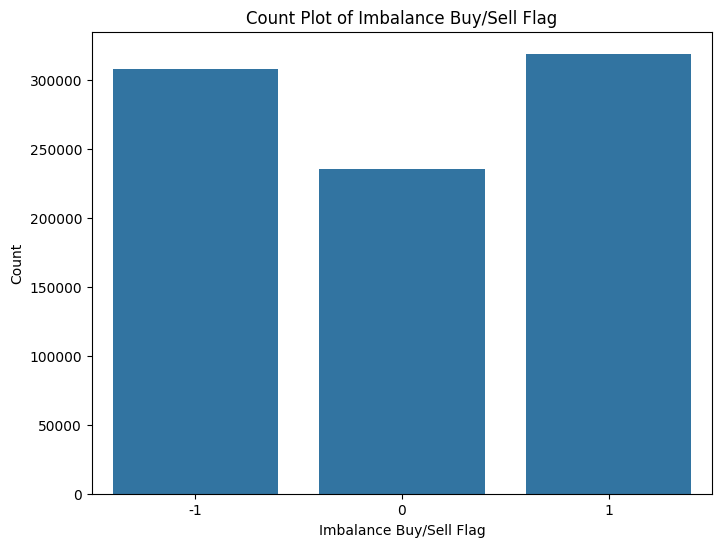

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='imbalance_buy_sell_flag', data=df_train)
plt.title('Count Plot of Imbalance Buy/Sell Flag')
plt.xlabel('Imbalance Buy/Sell Flag')
plt.ylabel('Count')
plt.show()

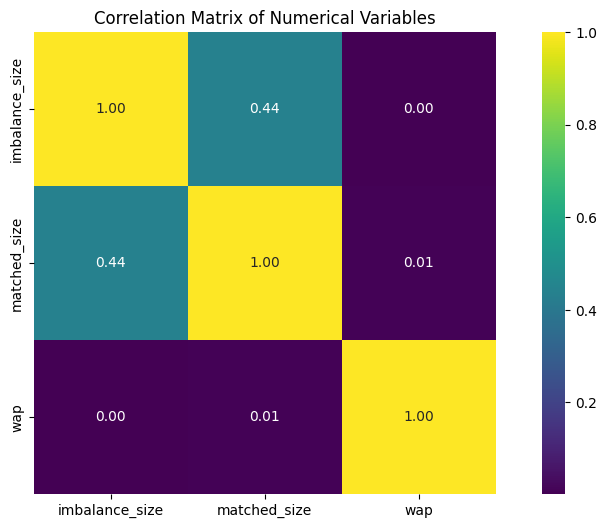

In [ ]:
numerical_vars = ['imbalance_size', 'matched_size', 'wap']

# Compute the correlation matrix
correlation_matrix = df_train[numerical_vars].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

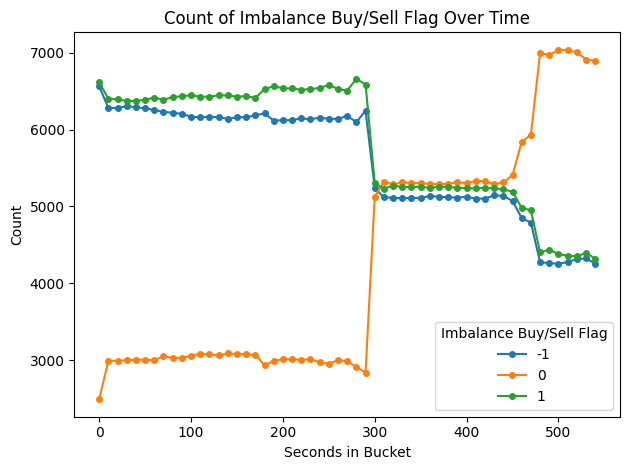

In [ ]:
imbalance_counts = df_train.groupby(['seconds_in_bucket', 'imbalance_buy_sell_flag']).size().unstack(fill_value=0)
imbalance_counts.plot(kind='line', marker='o', markersize=4)
plt.title('Count of Imbalance Buy/Sell Flag Over Time')
plt.xlabel('Seconds in Bucket')
plt.ylabel('Count')
plt.legend(title='Imbalance Buy/Sell Flag')
plt.tight_layout()
plt.show()

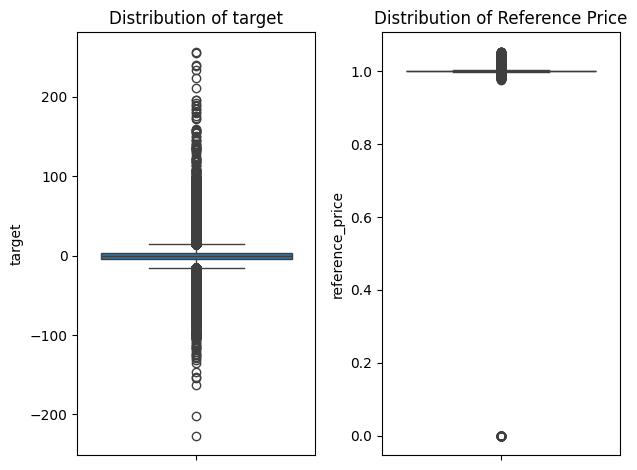

In [ ]:
plt.subplot(1, 2, 1)
sns.boxplot(data=df_train, y='target')
plt.title('Distribution of target')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_train, y='reference_price')
plt.title('Distribution of Reference Price')

plt.tight_layout()
plt.show()


## **1.2. Model deployment**


In [ ]:
import lightgbm as lgbm
lgbm_model = lgbm.LGBMRegressor(objective='mae', n_estimators=500, random_state=1234)
lgbm_model.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2804
[LightGBM] [Info] Number of data points in the train set: 861557, number of used features: 13
[LightGBM] [Info] Start training from score -0.029802


LGBMRegressor(n_estimators=500, objective='mae', random_state=1234)

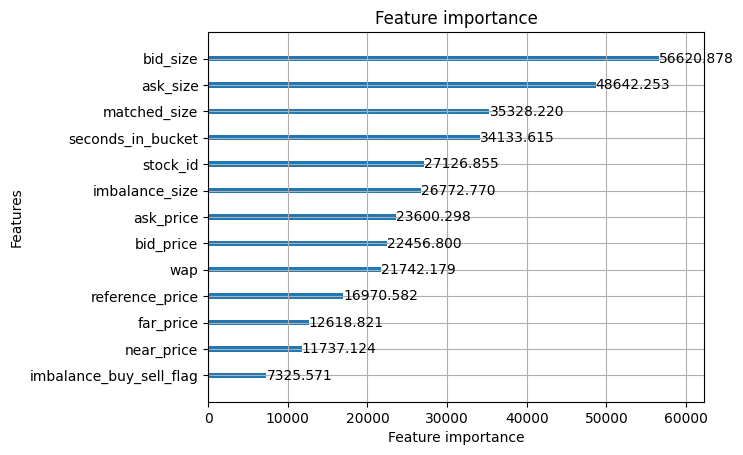

In [ ]:
lgbm.plot_importance(lgbm_model, importance_type="gain")
plt.show()

**It is evident from above that bid_size seems to be the most important parameter based on 'gain' as the importance parameter**

In [ ]:
lgbm_model = lgbm.LGBMRegressor(objective='mae',
                                n_estimators=895,
                                num_leaves= 25,
                                max_depth= 7)
lgbm_model.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2804
[LightGBM] [Info] Number of data points in the train set: 861557, number of used features: 13
[LightGBM] [Info] Start training from score -0.029802


LGBMRegressor(max_depth=7, n_estimators=895, num_leaves=25, objective='mae')

In [ ]:
#Make predictions on test data
y_pred = lgbm_model.predict(x_test)

In [ ]:
#Calculate the mean absolute error
mean_absolute_error(rev_target_modified['revealed_target'],y_pred)

5.58403336764393

Achieved a MAE of **5.584**. We will try optimizing the baseline model


# **2. Improvements over the model**

## **2.1 Optimization using Optuna**


The score improved to **5.3878** after using optuna for optimization.


In [ ]:
x = x_train.copy()
y = y_train.copy()

In [ ]:
def objective(trial):
    params = {
        'random_seed':123,
        'n_estimators'    :trial.suggest_int('n_estimators', 300, 1000),
        'num_leaves'      :trial.suggest_int('num_leaves', 4, 32),
        'max_depth'       :trial.suggest_int("max_depth",1,10)}

    model = lgbm.LGBMRegressor(**params)
    model.fit(x,y)
    y_pred = model.predict(x)
    score = mean_absolute_error(y, y_pred)

    return score

In [ ]:
#study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123))
#study.optimize(objective, n_trials=50)
#study.best_params

Above optimization is commented, since it takes a couple of hours to run this optimization

## 2.2. Adding new feature (imbalance_size)

As is evident from the Light GBM "importance" chart, not Price-related but Size-related features were regarded as important by LightGBM, thus we will try to create Size-related new features. First, let's create the ratio between imbalance_size and matched_size.  

The score improved to **5.3866** because of the new feature.

In [ ]:
#def pre_process1(df):
#    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
#    return df

## 2.3. Add imbalance_size

By adding 2 more features related to imbalance between bid-size and ask-size, it lead to a further improvement of the score to **5.3852**.  



For these features, I referred to below great notebook.   
https://www.kaggle.com/code/renatoreggiani/optv-lightgbm

In [ ]:
#def pre_process1(df):
#
#    df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
#    df['imbl_size2'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size'])
#
#    return df

In [ ]:
# Original
# def pre_process1(df):

#     df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
#     #---> improve 0.0012

#     df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
#     df['imbl_size2'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size'])
#     #---> improve 0.0014

#     df['bid_size_diff'] = df[["stock_id", "date_id", "bid_size"]].groupby(["stock_id","date_id"]).diff()
#     df['ask_size_diff'] = df[["stock_id", "date_id", "ask_size"]].groupby(["stock_id","date_id"]).diff()
#     #<--- "diff" doesn't work well

#     df["bid_size_over_ask_size"] = df["bid_size"].div(df["ask_size"])
#     df["bid_price_over_ask_price"] = df["bid_price"].div(df["ask_price"])
#     #---> improve 0.0018

#     return df

In [ ]:
# Edited
def pre_process1(df):

    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
    #---> improve 0.0012

    df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
    df['imbl_size2'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size'])
    #---> improve 0.0014

#     df['bid_size_diff'] = df[["stock_id", "date_id", "bid_size"]].groupby(["stock_id","date_id"]).diff()
#     df['ask_size_diff'] = df[["stock_id", "date_id", "ask_size"]].groupby(["stock_id","date_id"]).diff()
#     #<--- "diff" doesn't work well

#     df["bid_size_over_ask_size"] = df["bid_size"].div(df["ask_size"])
#     df["bid_price_over_ask_price"] = df["bid_price"].div(df["ask_price"])
    #---> improve 0.0018

    return df

In [ ]:
df_train = pre_process1(df_train)
df_train = feature_cols(df_train)
df_train.fillna(0, inplace = True)
df_train

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,imbalance_ratio,imbl_size1,imbl_size2
0,0,0,3180602.69,1,0.999812,13380276.64,0.000000,0.000000,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0.237708,0.754340,-0.615890
1,1,0,166603.91,-1,0.999896,1642214.25,0.000000,0.000000,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0.101451,-0.728751,-0.815787
2,2,0,302879.87,-1,0.999561,1819368.03,0.000000,0.000000,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0.166475,0.332935,-0.714567
3,3,0,11917682.27,-1,1.000171,18389745.62,0.000000,0.000000,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0.648061,-0.990340,-0.213547
4,4,0,447549.96,-1,0.999532,17860614.95,0.000000,0.000000,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0.025058,0.948687,-0.951109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196917,149,360,5831841.04,-1,0.998280,30317959.43,0.948755,0.980175,0.998230,20782.65,0.998482,64343.50,0.998291,3.910065,0.192356,-0.511721,-0.677351
196918,151,360,0.00,0,1.001582,78660924.96,1.001582,1.001582,1.001582,598773.42,1.001752,289990.08,1.001696,2.650022,0.000000,0.347430,-1.000000
196919,152,360,5210085.00,-1,0.998390,20268162.59,0.971376,0.974561,0.998390,5968.87,0.998617,8779.75,0.998482,-3.889799,0.257058,-0.190586,-0.591017
196920,154,360,0.00,0,0.999595,3994944.81,0.999595,0.999595,0.999269,47431.02,0.999595,24658.68,0.999483,6.480217,0.000000,0.315889,-1.000000


## 2.4. Add bid/ask ratio in size and price

Approach to use "diff" didn't work well, but it seems imbalance-related new features work well, thus let's try to add ratio between bid and ask in price and size. The result is, public score was improved to **5.3834**, which is the best improvement so far. (For these new features, I refered to the above-mentioned link. Hoiwever, I didn't adopt the new features created by simple "plus" or "minus" of existing 2 features, since in my experiences I think those simple new features don't work. I guess simple plus/minus relationship between existing features are already considered by LGBM during study.)

- unnecessary calculations - calculating the same value multiple times. For example, the following code calculates the imbalance ratio twice:
  - df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
  - df['imbl_size2'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size'])
  
- caching. Caching can be used to store the results of expensive calculations, so that they can be reused later without having to recalculate them.


In [ ]:
x_train = feature_cols(df_train.drop(columns='target'))
y_train = df_train['target'].values

In [ ]:
# import numpy as np
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [500, 1000, 2000],
#     'num_leaves': [25, 50, 100],
#     'max_depth': [5, 7, 10]
# }

# grid_search = GridSearchCV(estimator=lgbm.LGBMRegressor(objective='mae'), param_grid=param_grid, cv=5)
# grid_search.fit(x_train, y_train)

# best_params = grid_search.best_params_

# # Create and train a new model with the best hyperparameters
# lgbm_model = lgbm.LGBMRegressor(objective='mae', **best_params)
# lgbm_model.fit(x_train, y_train)


In [ ]:
# !pip install hyperopt --upgrade

In [ ]:
# import hyperopt
# from lightgbm import LGBMRegressor

# def objective(params):
#     model = LGBMRegressor(objective='mae',
#                          n_estimators=params['n_estimators'],
#                          num_leaves=params['num_leaves'],
#                          max_depth=params['max_depth'])
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_train)
#     mae = mean_absolute_error(y, y_pred)
#     return mae

# search_space = {
#     'n_estimators': hyperopt.hp.choice('n_estimators', range(500, 1000)),
#     'num_leaves': hyperopt.hp.choice('num_leaves', range(20, 50)),
#     'max_depth': hyperopt.hp.choice('max_depth', range(5, 10))
# }

# trials = hyperopt.Trials()
# best_hyperparams = hyperopt.fmin(objective, search_space, algo=hyperopt.tpe.suggest, max_evals=13, trials=trials)

# best_hyperparams = trials.best_trial['misc']['vals']

# lgbm_model = LGBMRegressor(objective='mae',
#                             n_estimators=best_hyperparams['n_estimators'],
#                             num_leaves=best_hyperparams['num_leaves'],
#                             max_depth=best_hyperparams['max_depth'])
# lgbm_model.fit(x_train, y_train)

# y_pred = lgbm_model.predict(x_test)


In [ ]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 20,
    "max_bin": 512,
    "num_iterations": 1000,
    "force_col_wise": 'true'
}

lgbm_model = lgbm.LGBMRegressor(**params)
lgbm_model.fit(x_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              force_col_wise='true', learning_rate=0.005, max_bin=512,
              max_depth=8, metric=['l1', 'l2'], num_iterations=1000,
              num_leaves=20, objective='regression', task='train', verbose=0)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

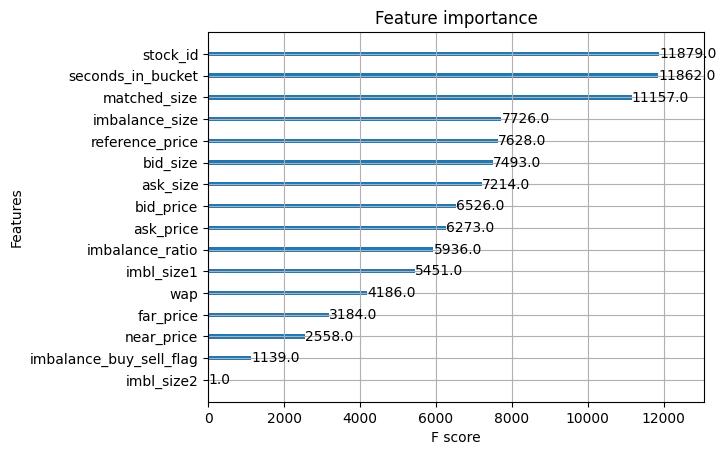

In [ ]:
import xgboost as xgb

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=895,
                             max_depth=7)

# Train the model
xgb_model.fit(x_train, y_train)

xgb.plot_importance(xgb_model)
plt.show()

In [ ]:
import xgboost as xgb
# Create an XGBoost regressor with the gpu_hist tree construction algorithm
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=895,
                             max_depth=7,
                             tree_method='gpu_hist')

# Train the model
xgb_model.fit(x_train, y_train)

# Plot the feature importances
xgb.plot_importance(xgb_model)

# Save the model
# xgb_model.save_model('xgb_model.bin')
# Save as JSON file
# xgb_model.save_model("xgb_model.json")
# Save as TXT file
# xgb_model.save_model("xgb_model.txt")

In [ ]:
# # Make predictions on the test data
y_pred = xgb_model.predict(X_test)

In [ ]:
# lgbm_model = lgbm.LGBMRegressor(objective='mae',
#                                 n_estimators=895,
#                                 num_leaves= 25,
#                                 max_depth= 7)
# lgbm_model.fit(x_train, y_train)

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# rf_model = RandomForestRegressor(n_estimators=895,
#                                 max_depth= 8,criterion="squared_error",bootstrap=True)
# rf_model.fit(x_train, y_train)

In [ ]:
lgbm.plot_importance(lgbm_model, importance_type="gain")
plt.show()

# 7. Submission

As I said, this notebook is just a starter, and thus I'll submit at this point.   
In this competition, API provided by kaggle should be used.  

In [ ]:
# import optiver2023
# env = optiver2023.make_env()
# iter_test = env.iter_test()

In [ ]:
# counter = 0
# for (test, revealed_targets, sample_prediction) in iter_test:
#     test = pre_process1(test)
#     test_df = feature_cols(test)
#     sample_prediction['target'] = lgbm_model.predict(test_df)
#     env.predict(sample_prediction)

#     counter += 1

In [ ]:
# basic edits
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    test = pre_process1(test)
    test_df = feature_cols(test)
    sample_prediction['target'] = xgb_model.predict(test_df)
    env.predict(sample_prediction)

    counter += 1